<h1 style="text-align:center; color:#191970; font-weight:bold;">Value at Risk (VaR) as a Tool for Market Risk Assessment: Lessons from Historical Financial Crises</h1>

Import necessary libraries

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import datetime as dt
import yfinance as yf
import os

In [15]:
sns.set_style("whitegrid")

plt.rc("figure", figsize=(16, 8))
plt.rc("savefig", dpi=90)
plt.rc("font", family="sans-serif")
plt.rc("font", size=14)

<h2 style="color:#191970; font-weight:bold;">Methodology: A 3 Phase Framework</h2>

## <span style="color:darkred; font-weight:bold;">Phase 1: Data Preprocessing and Simulation Creation</span>


### Data Collection

In [16]:
tickers = ['^FTSE', '^GSPC', '^N225']
start_date = '2007-01-01'
end_date = '2009-01-01'

data = yf.download(tickers, start=start_date, end=end_date)

[*********************100%%**********************]  3 of 3 completed


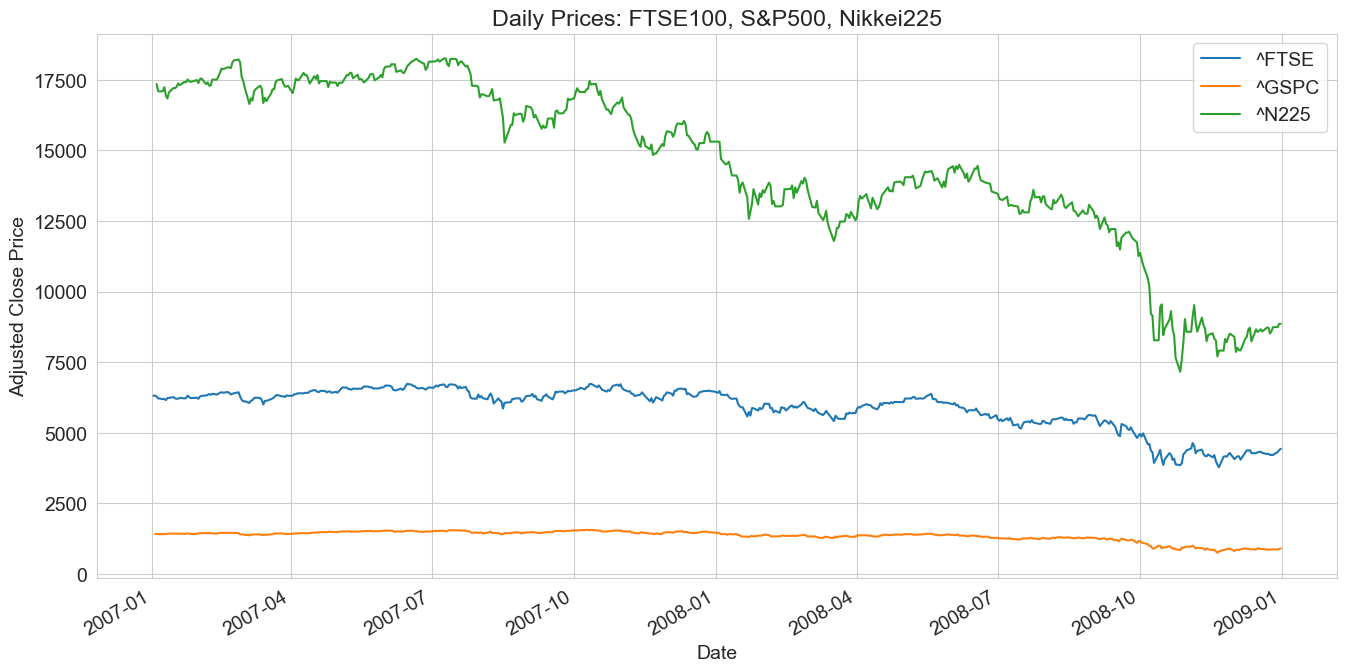

In [17]:
prices = data['Adj Close'].copy()

# Forward fill missing values
prices.ffill(inplace=True)

# Plotting the prices
prices.plot()
plt.title('Daily Prices: FTSE100, S&P500, Nikkei225')
plt.ylabel('Adjusted Close Price')
plt.show()

### Log Returns Transformation

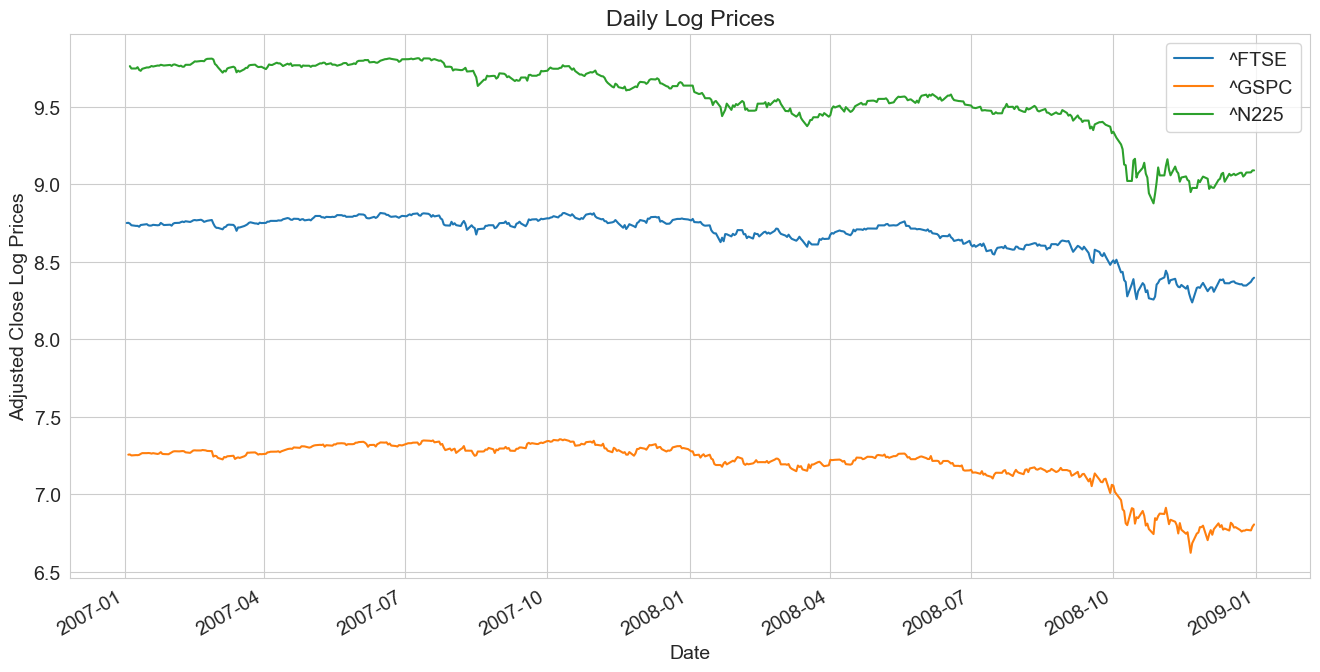

In [18]:
np.log(prices).plot()
plt.ylabel('Adjusted Close Log Prices')
plt.title('Daily Log Prices')
plt.show()

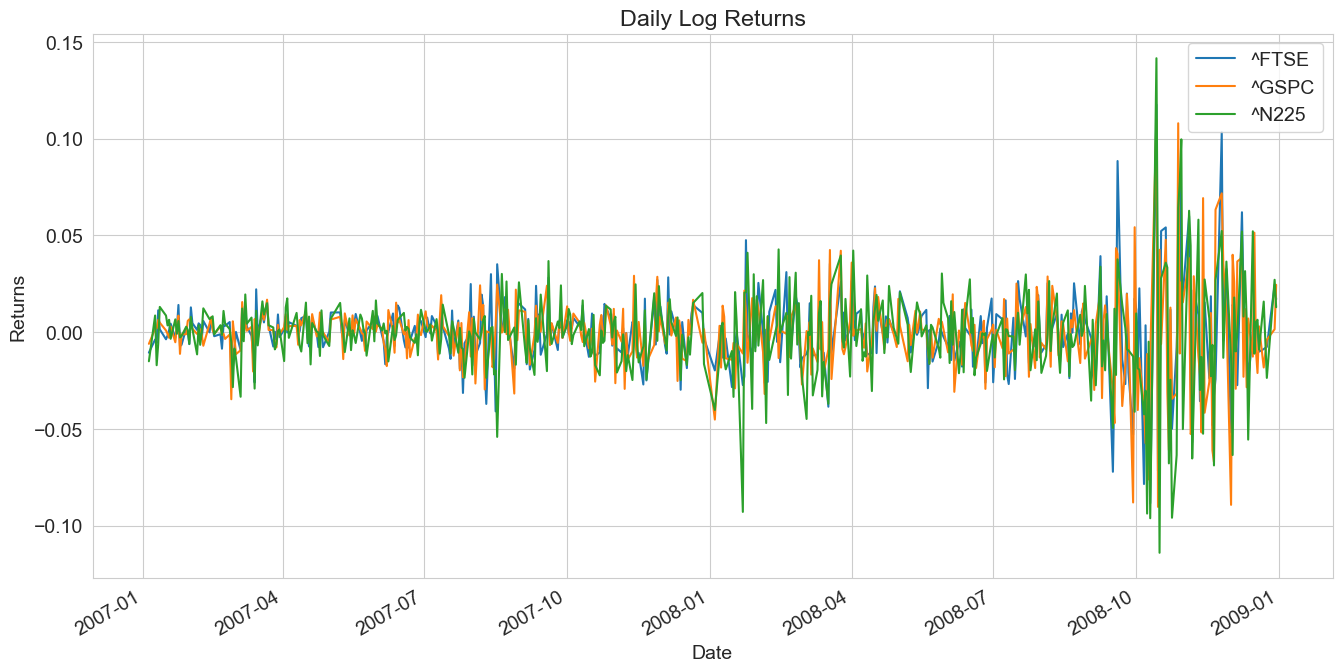

In [19]:
returns = data['Adj Close'].dropna().pct_change()

returns.plot()
plt.title('Daily Log Returns')
plt.ylabel('Returns')
plt.show()

In [20]:
returns_summary = (returns*100).describe()
returns_summary.round(2)[1:]

,^FTSE,^GSPC,^N225
mean,-0.06,-0.08,-0.12
std,1.95,2.03,2.30
min,-8.85,-9.03,-11.41
25%,-0.87,-0.90,-1.06
50%,-0.04,0.07,-0.01
75%,0.83,0.66,0.89
max,11.75,10.99,14.15


In [21]:
returns_summary = (returns*100).describe()
latex_table = returns_summary.round(2).to_latex()
print(latex_table)

\begin{tabular}{lrrr}
\toprule
 & ^FTSE & ^GSPC & ^N225 \\
\midrule
count & 466.000000 & 466.000000 & 466.000000 \\
mean & -0.060000 & -0.080000 & -0.120000 \\
std & 1.950000 & 2.030000 & 2.300000 \\
min & -8.850000 & -9.030000 & -11.410000 \\
25% & -0.870000 & -0.900000 & -1.060000 \\
50% & -0.040000 & 0.070000 & -0.010000 \\
75% & 0.830000 & 0.660000 & 0.890000 \\
max & 11.750000 & 10.990000 & 14.150000 \\
\bottomrule
\end{tabular}



In [22]:
data

Adj Close                                   Close               \
                  ^FTSE        ^GSPC         ^N225        ^FTSE        ^GSPC   
Date                                                                           
2007-01-02  6310.899902          NaN           NaN  6310.899902          NaN   
2007-01-03  6319.000000  1416.599976           NaN  6319.000000  1416.599976   
2007-01-04  6287.000000  1418.339966  17353.669922  6287.000000  1418.339966   
2007-01-05  6220.100098  1409.709961  17091.589844  6220.100098  1409.709961   
2007-01-08  6194.200195  1412.839966           NaN  6194.200195  1412.839966   
...                 ...          ...           ...          ...          ...   
2008-12-25          NaN          NaN   8599.500000          NaN          NaN   
2008-12-26          NaN   872.799988   8739.519531          NaN   872.799988   
2008-12-29  4319.399902   869.419983   8747.169922  4319.399902   869.419983   
2008-12-30  4392.700195   890.640015   8859.559570  4392.700195   890.640015   
2008-12-31  4434.200195   903.250000           NaN  4434.200195   903.250000   

                                 High                                     Low  \
                   ^N225        ^FTSE        ^GSPC         ^N225        ^FTSE   
Date                                                                            
2007-01-02           NaN  6312.500000          NaN           NaN  6220.799805   
2007-01-03           NaN  6322.000000  1429.420044           NaN  6296.000000   
2007-01-04  17353.669922  6319.000000  1421.839966  17379.460938  6261.000000   
2007-01-05  17091.589844  6287.000000  1418.339966  17327.130859  6220.100098   
2007-01-08           NaN  6246.000000  1414.979980           NaN  6187.000000   
...                  ...          ...          ...           ...          ...   
2008-12-25   8599.500000          NaN          NaN   8599.500000          NaN   
2008-12-26   8739.519531          NaN   873.739990   8740.759766          NaN   
2008-12-29   8747.169922  4326.299805   873.700012   8763.669922  4216.600098   
2008-12-30   8859.559570  4406.100098   891.119995   8859.559570  4319.399902   
2008-12-31           NaN  4456.200195   910.320007           NaN  4392.700195   

                                              Open                             \
                  ^GSPC         ^N225        ^FTSE        ^GSPC         ^N225   
Date                                                                            
2007-01-02          NaN           NaN  6220.799805          NaN           NaN   
2007-01-03  1407.859985           NaN  6310.899902  1418.030029           NaN   
2007-01-04  1408.430054  17315.759766  6319.000000  1416.599976  17322.500000   
2007-01-05  1405.750000  17011.099609  6287.000000  1418.339966  17315.539062   
2007-01-08  1403.969971           NaN  6220.100098  1409.260010           NaN   
...                 ...           ...          ...          ...           ...   
2008-12-25          NaN   8531.160156          NaN          NaN   8531.509766   
2008-12-26   866.520020   8611.360352          NaN   869.510010   8642.139648   
2008-12-29   857.070007   8638.599609  4216.600098   872.369995   8726.309570   
2008-12-30   870.580017   8702.950195  4319.399902   870.580017   8716.280273   
2008-12-31   889.669983           NaN  4392.700195   890.590027           NaN   

                  Volume                             
                   ^FTSE         ^GSPC        ^N225  
Date                                                 
2007-01-02  1.074946e+09           NaN          NaN  
2007-01-03  1.606893e+09  3.429160e+09          NaN  
2007-01-04  1.902876e+09  3.004460e+09   80100000.0  
2007-01-05  1.622439e+09  2.919400e+09  158600000.0  
2007-01-08  1.326701e+09  2.763340e+09          NaN  
...                  ...           ...          ...  
2008-12-25           NaN           NaN   61200000.0  
2008-12-26           NaN  1.880050e+09   75800000.0  
2008-12-29  4.411068e+08  3.3

### EHS VaR (Student's t-distribution)

In [23]:
confidence_level = 0.95
time_horizon = 1
common_degrees_of_freedom = 5  # the lower the DF (v), the fatter the tails 

var_results_list = []

#'returns' is the DataFrame containing my log returns
for index_name in returns.columns:
    var = stats.t.ppf(1 - confidence_level, common_degrees_of_freedom, 
                      loc=returns[index_name].mean(), 
                      scale=returns[index_name].std())
    var_results_list.append({'tickers': index_name, 'VaR': var})

# Create DataFrame from the list
var_results = pd.DataFrame(var_results_list)

# Check for NaN values
if var_results.isnull().values.any():
    print("Warning: NaN values detected in the result.")

print(var_results)

  tickers       VaR
0   ^FTSE -0.039813
1   ^GSPC -0.041668
2   ^N225 -0.047544


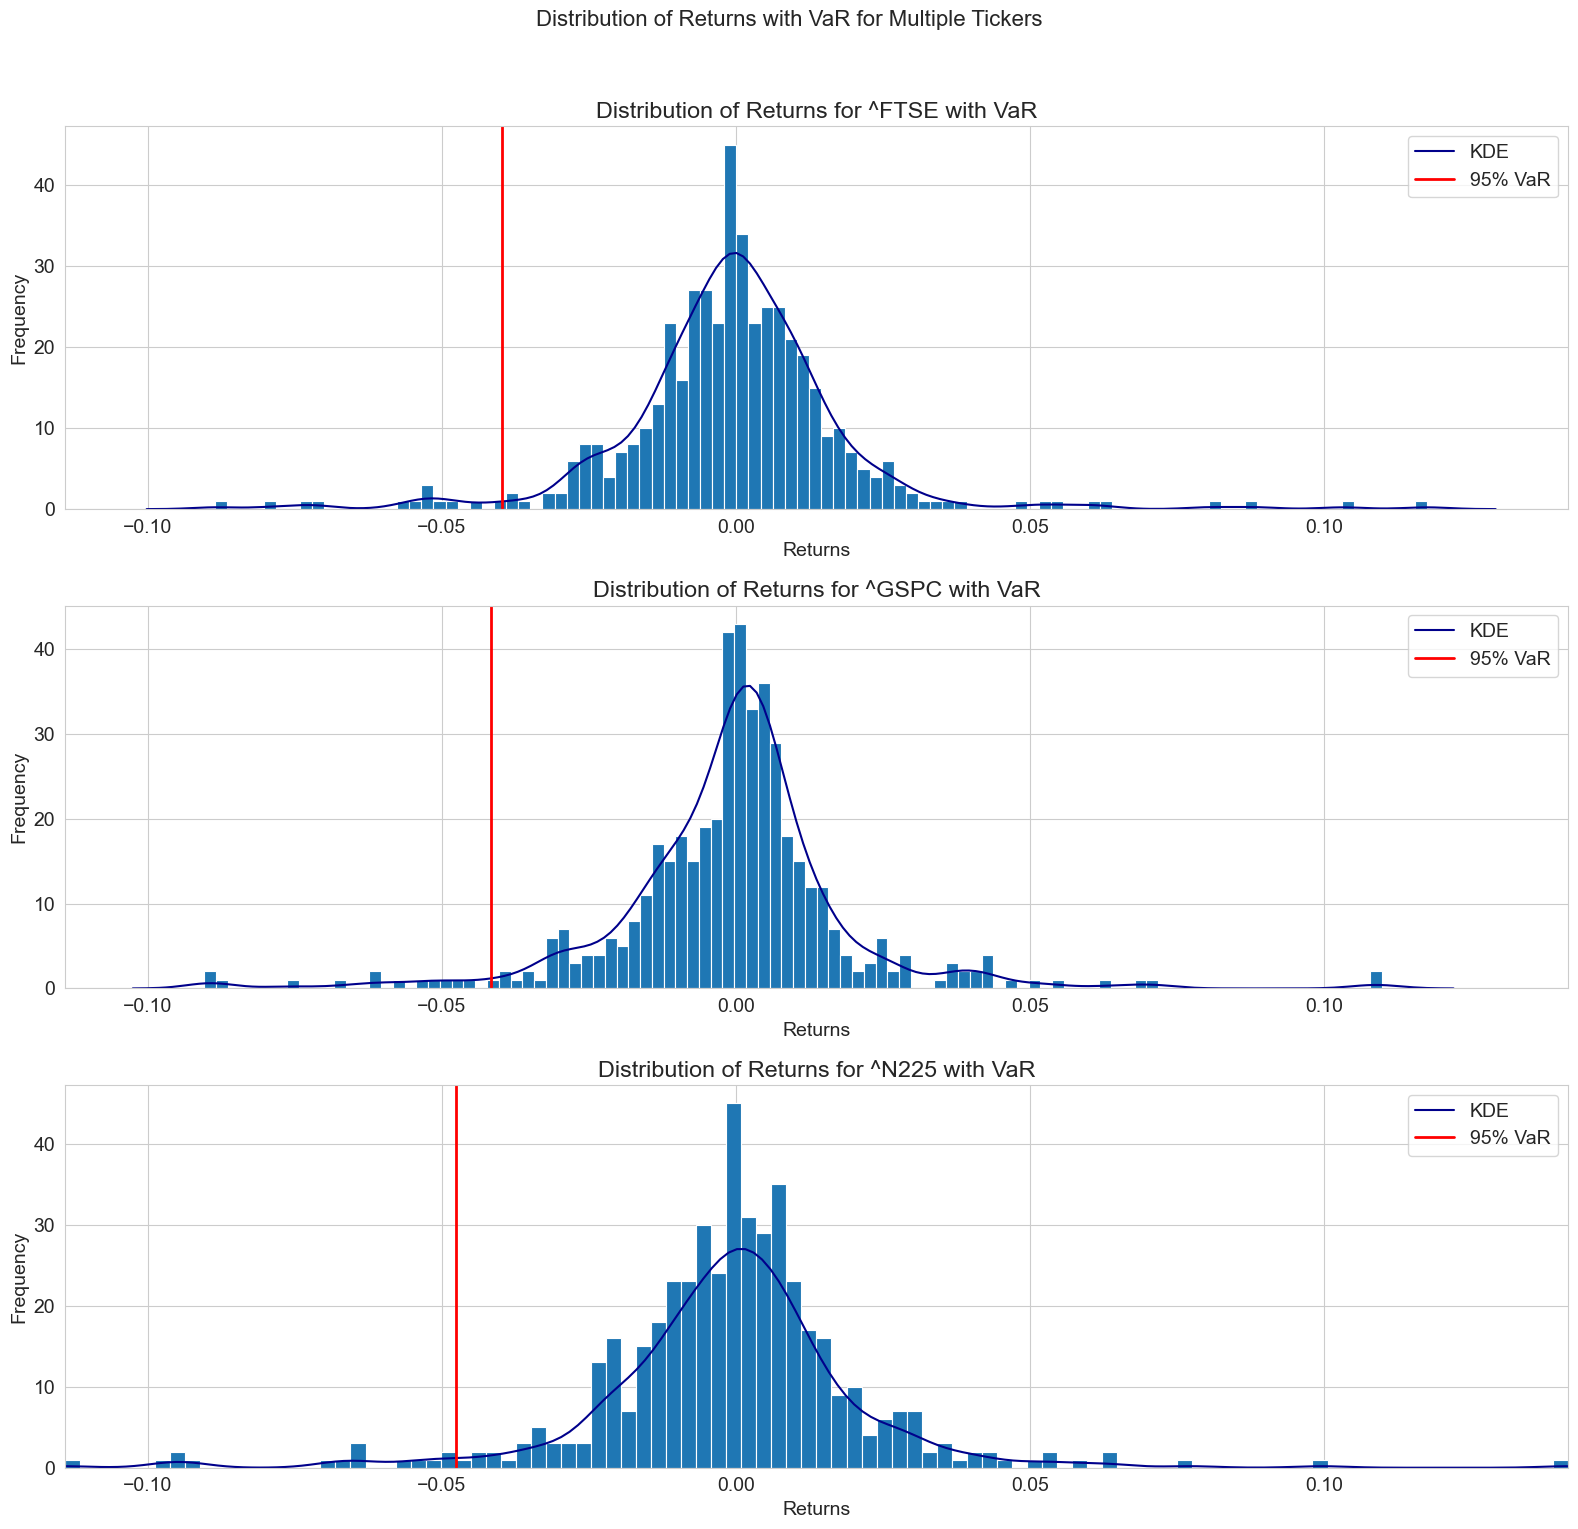

In [24]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(16, 15))

# Get the overall minimum and maximum values of log returns across all tickers
min_return = returns.min().min()
max_return = returns.max().max()

# Plot distribution with KDE for each ticker in a subplot
for i, index_name in enumerate(returns.columns):
    sns.histplot(returns[index_name], color='#1f77b4', bins=100, ax=axes[i], alpha=1, kde_kws={'bw_method': 25})  # Specify bandwidth for histplot

# Create a separate KDE plot with a different color 
    sns.kdeplot(returns[index_name], color='darkblue', ax=axes[i], label='KDE', bw_method=0.2)  # Specify bandwidth for kdeplot
    
    axes[i].axvline(var_results[var_results['tickers'] == index_name]['VaR'].iloc[0], color='red', linestyle='solid', linewidth=2, label='95% VaR')
    axes[i].set_title(f'Distribution of Returns for {index_name} with VaR')
    axes[i].set_xlabel('Returns')
    axes[i].set_ylabel('Frequency')
    axes[i].set_xlim(min_return, max_return)  
    axes[i].legend()

fig.suptitle('Distribution of Returns with VaR for Multiple Tickers', fontsize=16, y=1.02)

# Adjust layout for better spacing
plt.tight_layout()

plt.savefig('Distribution_of_Returns_with_VaR.png')

# Show the plot
plt.show()


## <span style="color:darkred; font-weight:bold;">Phase 2: Model Sensitivity and Backtesting</span>

### Sensitivity Testing

#### Sensitivity Analysis: Confidence Level

In [25]:
def calculate_var(returns, confidence_level=0.95, time_horizon=1, degrees_of_freedom=5):
    var_results_list = []

    for index_name in returns.columns:
        var = stats.t.ppf(1 - confidence_level, degrees_of_freedom,
                          loc=returns[index_name].mean(),
                          scale=returns[index_name].std())
        var_results_list.append({'tickers': index_name, 'VaR': var})

    var_results = pd.DataFrame(var_results_list)

    # Check for NaN values
    if var_results.isnull().values.any():
        print("Warning: NaN values detected in the result.")

    return var_results

# Original calculation
confidence_level_original = 0.95
time_horizon_original = 1
common_degrees_of_freedom = 5

var_results_original = calculate_var(returns, confidence_level_original, time_horizon_original, common_degrees_of_freedom)
print("Original results:")
print(var_results_original)

# Sensitivity analysis with different confidence levels
confidence_levels = [0.90, 0.99]

for level in confidence_levels:
    var_results_sensitivity = calculate_var(returns, confidence_level=level, time_horizon=time_horizon_original, degrees_of_freedom=common_degrees_of_freedom)
    print(f"Results for confidence level {level}:")
    print(var_results_sensitivity)

Original results:
  tickers       VaR
0   ^FTSE -0.039813
1   ^GSPC -0.041668
2   ^N225 -0.047544
Results for confidence level 0.9:
  tickers       VaR
0   ^FTSE -0.029316
1   ^GSPC -0.030731
2   ^N225 -0.035137
Results for confidence level 0.99:
  tickers       VaR
0   ^FTSE -0.066095
1   ^GSPC -0.069050
2   ^N225 -0.078605


#### Sensitivity Analysis: Time Horizon

In [26]:
common_confidence_level = 0.95
common_degrees_of_freedom = 5  # the lower the DF (v), the fatter the tails 

time_horizons = [1, 5, 21]  # Different time horizons to analyze

var_results_list = []

# 'returns' is the DataFrame containing my log returns
for time_horizon in time_horizons:
    temp_var_results = []

    for index_name in returns.columns:
        var = stats.t.ppf(1 - common_confidence_level, common_degrees_of_freedom, 
                          loc=returns[index_name].mean(), 
                          scale=returns[index_name].std() * (time_horizon ** 0.5))
        temp_var_results.append({'tickers': index_name, 'VaR': var, 'Time Horizon': time_horizon})

    var_results_list.extend(temp_var_results)

# Create DataFrame from the list
var_results = pd.DataFrame(var_results_list)

# Check for NaN values
if var_results.isnull().values.any():
    print("Warning: NaN values detected in the result.")

print(var_results)

  tickers       VaR  Time Horizon
0   ^FTSE -0.039813             1
1   ^GSPC -0.041668             1
2   ^N225 -0.047544             1
3   ^FTSE -0.088308             5
4   ^GSPC -0.092192             5
5   ^N225 -0.104857             5
6   ^FTSE -0.180367            21
7   ^GSPC -0.188106            21
8   ^N225 -0.213659            21


### Time Series Plot

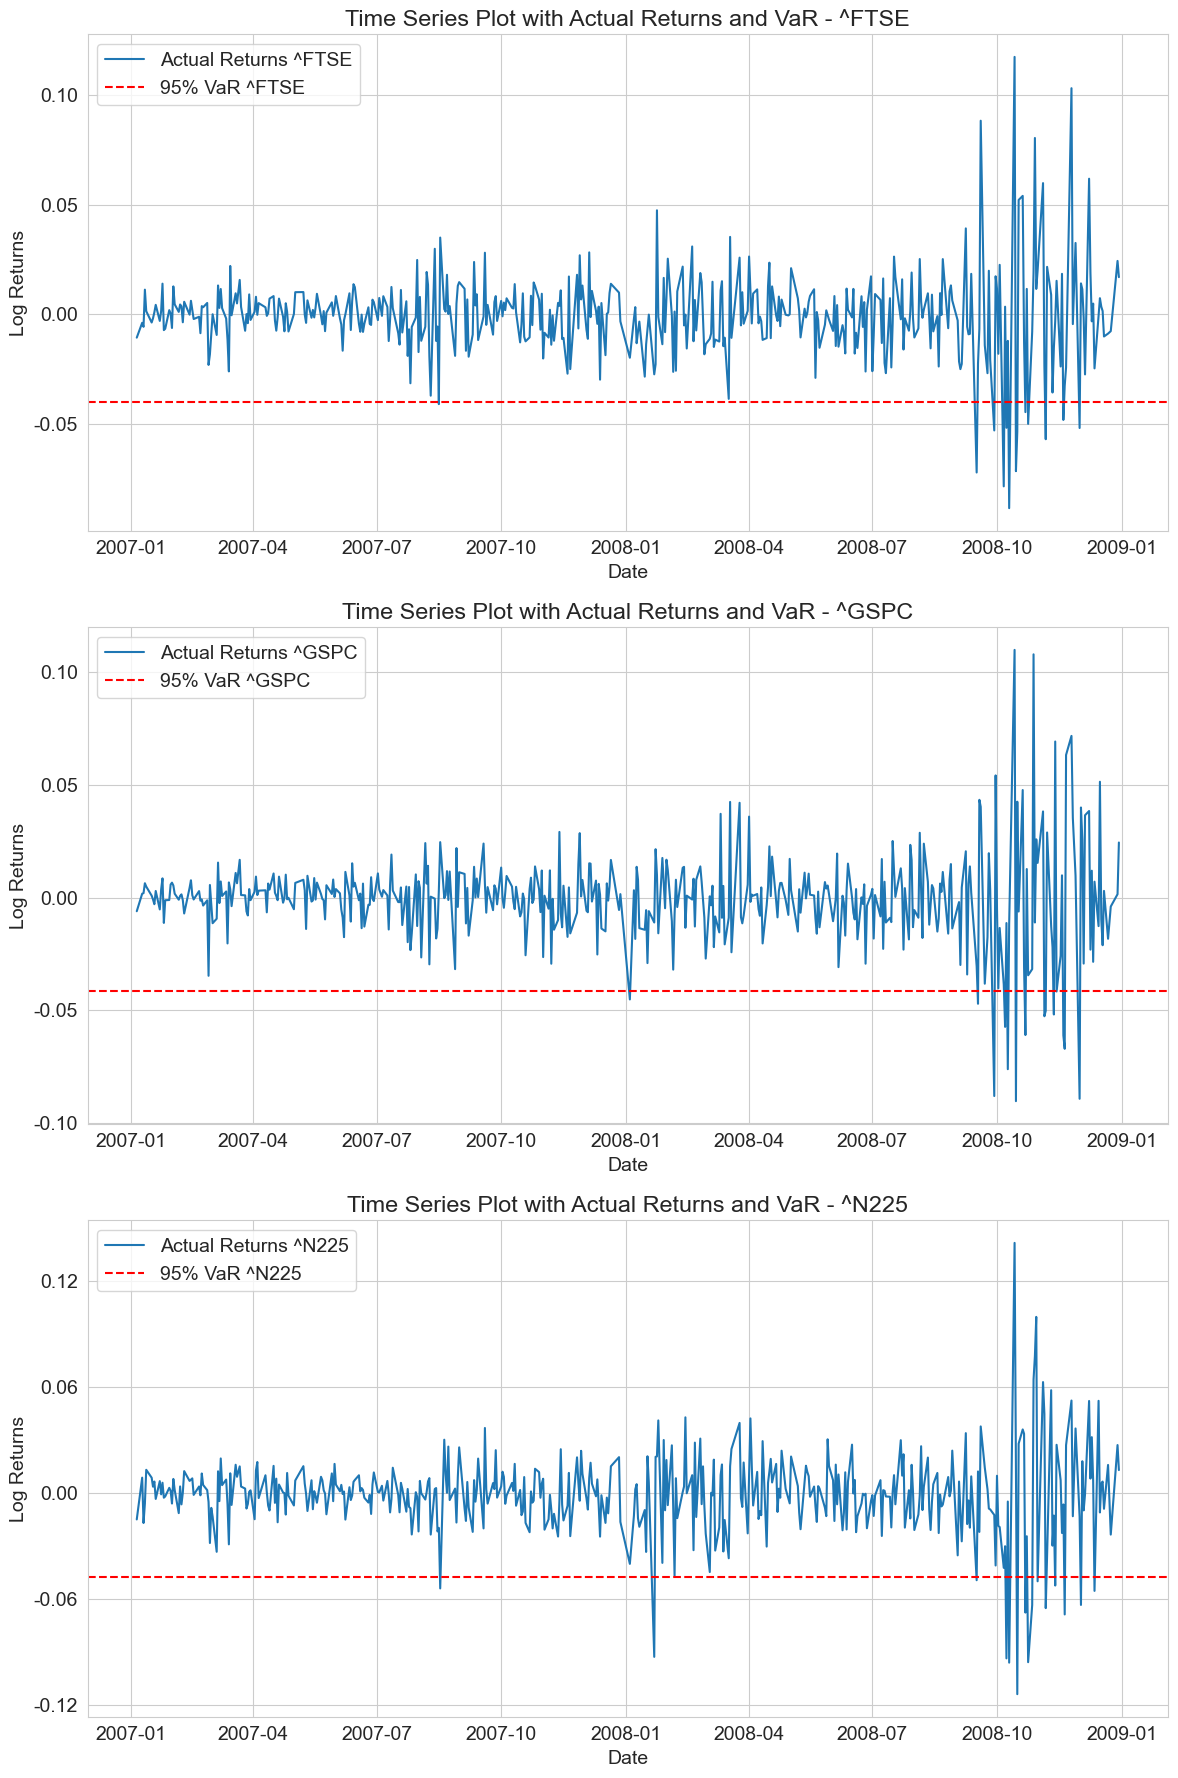

In [27]:
from matplotlib.ticker import MaxNLocator, FuncFormatter

# Create a single figure
fig, axes = plt.subplots(3, 1, figsize=(12, 18))

# Plotting actual log returns and VaR for each index
for i, index_name in enumerate(returns.columns):
    
    # Actual log returns
    axes[i].plot(returns.index, returns[index_name], label=f'Actual Returns {index_name}')
    
    # VaR line
    axes[i].axhline(var_results[var_results['tickers'] == index_name]['VaR'].iloc[0],
                    linestyle='dashed', color='red', label=f'95% VaR {index_name}')

    axes[i].set_title(f'Time Series Plot with Actual Returns and VaR - {index_name}')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Log Returns')

    # Set y-axis ticks to 2 decimal places
    axes[i].yaxis.set_major_locator(MaxNLocator(nbins=5, prune='both'))
    axes[i].yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.2f}'.format(x)))

    axes[i].legend()

# Adjust layout for better spacing
plt.tight_layout()

# Save the figure as a PNG
plt.savefig('Time_Series_Plot_All.png')

# Show the figure
plt.show()

### Backtesting

#### Exceedance Test

In [28]:
# Create an empty list to store exceedance count results
exceedance_results = []

# Exceedance count test
for index_name in returns.columns:
    va_r = var_results[var_results['tickers'] == index_name]['VaR'].iloc[0]
    exceedances = returns[returns[index_name] < va_r]
    num_exceedances = len(exceedances)

    # Append results to the list
    exceedance_results.append({'Index': index_name, 'Exceedance Count': num_exceedances})

# Create a DataFrame from the list
exceedance_df = pd.DataFrame(exceedance_results)

# Display the exceedance count results
print(exceedance_df)

   Index  Exceedance Count
0  ^FTSE                13
1  ^GSPC                14
2  ^N225                15


#### Kupiec Test

The Kupiec Test was performed in Excel outside of this environment. This was necessitated by issues related to the Python 3.12 version, which lacked the 'vartests' packages required for conducting the test.

In [29]:
# Create a folder to store the Excel files
output_folder = 'returns_excel_files/'
os.makedirs(output_folder, exist_ok=True)

# Export returns data for each index to a separate Excel file
for index_name in returns.columns:
    returns_data = pd.DataFrame({'Date': returns.index, 'Returns': returns[index_name]})
    excel_filename = f'{output_folder}{index_name}_returns.xlsx'
    returns_data.to_excel(excel_filename, index=False)
    print(f"Returns data for {index_name} exported to {excel_filename}")

Returns data for ^FTSE exported to returns_excel_files/^FTSE_returns.xlsx
Returns data for ^GSPC exported to returns_excel_files/^GSPC_returns.xlsx
Returns data for ^N225 exported to returns_excel_files/^N225_returns.xlsx
